In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [3]:
%pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [4]:
from tqdm import tqdm  # 引入进度条库
x_dic = {}
for i in tqdm(range(1, 101), desc="读取Excel中"):
    df = pd.read_excel('41586_2009_BFnature07634_MOESM271_ESM.xls', sheet_name = i, skiprows = 1)
    xi = df['East South Central Region'].tolist()# 提取该搜索词在 "East South Central" 这一特定地区的每周搜索量时间序列
    x_dic['x'+str(i)] = xi

读取Excel中: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


In [5]:
# 1. 打开文件一次，创建一个文件对象 xls
xls = pd.ExcelFile('41586_2009_BFnature07634_MOESM271_ESM.xls')
frames = []

# 2. 获取日期
df_base = pd.read_excel(xls, sheet_name=1, header=1)
data_dict = {'date': df_base['Date'].tolist()}

# 3. 循环读取（直接从 xls 对象读，速度快很多）
for i in range(1, 46):
    if i % 10 == 0: print(f"Processing query {i}...")
    # 注意这里传的是 xls 对象，而不是文件名字符串
    df = pd.read_excel(xls, sheet_name=i, header=1)
    df = df.set_index('Date')
    series = df['East South Central Region'].rename(f'query{i}')
    frames.append(series)
# 3. 使用 concat 命令横向合并 (axis=1)
# 这一步会自动处理长短不一的问题，自动对齐日期
dat = pd.concat(frames, axis=1)

# 处理缺失值（如果有的话，填0或者插值，这里演示直接删掉全空的行）
dat = dat.dropna(how='all')

print(f"合并完成！数据形状: {dat.shape}")
# Reset index to make 'Date' a regular column
dat = dat.reset_index()
dat.head()

Processing query 10...
Processing query 20...
Processing query 30...
Processing query 40...
合并完成！数据形状: (259, 45)


,Date,query1,query2,query3,query4,query5,query6,query7,query8,query9,...,query36,query37,query38,query39,query40,query41,query42,query43,query44,query45
0,2003-06-01,0.922,5.456,4.150,1.153,0.384,1.614,0.000,0.384,0.692,...,0.307,0.307,0.307,0.000,0.077,1.460,0.077,0.461,4.150,2.152
1,2003-06-08,0.479,5.555,7.183,1.724,0.766,1.820,0.000,0.575,0.575,...,0.958,0.096,0.766,0.192,0.000,2.586,0.000,0.192,3.448,2.873
2,2003-06-15,1.130,5.241,7.399,1.028,0.822,1.541,0.000,0.617,0.308,...,0.719,0.103,1.336,0.000,0.206,2.158,0.103,0.411,3.597,3.802
3,2003-06-22,1.149,4.700,4.805,0.209,0.731,1.358,0.104,0.836,0.209,...,0.836,0.000,0.940,0.418,0.209,1.880,0.000,0.104,2.925,3.760
4,2003-06-29,0.854,3.794,4.932,0.474,0.379,1.138,0.000,0.379,0.190,...,0.474,0.190,0.949,0.190,0.000,2.182,0.000,0.190,3.415,1.423


In [6]:
# 1. 删除多余的 'index' 列 (axis=1 表示列)
# errors='ignore' 表示如果它不存在（万一你没跑错）也不报错
dat = dat.drop(columns=['index'], errors='ignore')# columns=['index'] 表示删除名为 'index' 的列

# 2. 再次确认一下现在的样子
dat.head()

,Date,query1,query2,query3,query4,query5,query6,query7,query8,query9,...,query36,query37,query38,query39,query40,query41,query42,query43,query44,query45
0,2003-06-01,0.922,5.456,4.150,1.153,0.384,1.614,0.000,0.384,0.692,...,0.307,0.307,0.307,0.000,0.077,1.460,0.077,0.461,4.150,2.152
1,2003-06-08,0.479,5.555,7.183,1.724,0.766,1.820,0.000,0.575,0.575,...,0.958,0.096,0.766,0.192,0.000,2.586,0.000,0.192,3.448,2.873
2,2003-06-15,1.130,5.241,7.399,1.028,0.822,1.541,0.000,0.617,0.308,...,0.719,0.103,1.336,0.000,0.206,2.158,0.103,0.411,3.597,3.802
3,2003-06-22,1.149,4.700,4.805,0.209,0.731,1.358,0.104,0.836,0.209,...,0.836,0.000,0.940,0.418,0.209,1.880,0.000,0.104,2.925,3.760
4,2003-06-29,0.854,3.794,4.932,0.474,0.379,1.138,0.000,0.379,0.190,...,0.474,0.190,0.949,0.190,0.000,2.182,0.000,0.190,3.415,1.423


In [7]:
import pandas as pd
import datetime

# 1. 读取数据
# header=1 是因为 CSV 第一行通常是说明，第二行才是列名
df = pd.read_csv('ILINet.csv', header=1)

# 2. 定义日期转换函数 (MMWR Week -> Date)
# 逻辑：CDC的一周从周日开始。每年的第一周是包含1月4日的那一周。
def get_cdc_date(row):
    year = int(row['YEAR'])
    week = int(row['WEEK'])
    
    # 找到该年包含1月4日的那一天
    jan4 = datetime.datetime(year, 1, 4)

    # 找到那周的周日（作为第一周的起始日）
    # weekday(): 周一=0 ... 周日=6
    # jan4.weekday() + 1) % 7 计算出往回多少天到达周日
    start_week1 = jan4 - datetime.timedelta(days=(jan4.weekday() + 1) % 7)
    
    # 计算目标周的周日日期
    target_date = start_week1 + datetime.timedelta(weeks=week-1)
    return target_date

# 应用转换
df['date'] = df.apply(get_cdc_date, axis=1)

# 3. 执行对齐与切片 (Filtering)
# 设定目标时间范围
start_date = pd.Timestamp('2003-06-01')
end_date = pd.Timestamp('2008-05-11')

# 筛选数据
# df['date'] >= start_date  条件1：日期 >= 起始日期
# df['date'] <= end_date    条件2：日期 <= 结束日期
# 返回布尔值: [False, True, True, True, False]，只保留True对应的行
# & 执行逐元素AND运算
aligned_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()

# 重置索引，保持整洁
aligned_df = aligned_df.reset_index(drop=True)

# 4. 查看结果
print(f"数据行数: {len(aligned_df)}")
print("\n--- 头部数据 (Start) ---")
print(aligned_df[['date', 'YEAR', 'WEEK', '% WEIGHTED ILI']].head())
print("\n--- 尾部数据 (End) ---")
print(aligned_df[['date', 'YEAR', 'WEEK', '% WEIGHTED ILI']].tail())

数据行数: 259

--- 头部数据 (Start) ---
        date  YEAR  WEEK  % WEIGHTED ILI
0 2003-06-01  2003    23        0.450914
1 2003-06-08  2003    24        0.573115
2 2003-06-15  2003    25        0.279074
3 2003-06-22  2003    26        0.246446
4 2003-06-29  2003    27        0.108342

--- 尾部数据 (End) ---
          date  YEAR  WEEK  % WEIGHTED ILI
254 2008-04-13  2008    16         1.59652
255 2008-04-20  2008    17         1.65886
256 2008-04-27  2008    18         1.58509
257 2008-05-04  2008    19         1.44969
258 2008-05-11  2008    20         1.34343


In [8]:
y = aligned_df['% WEIGHTED ILI'].values

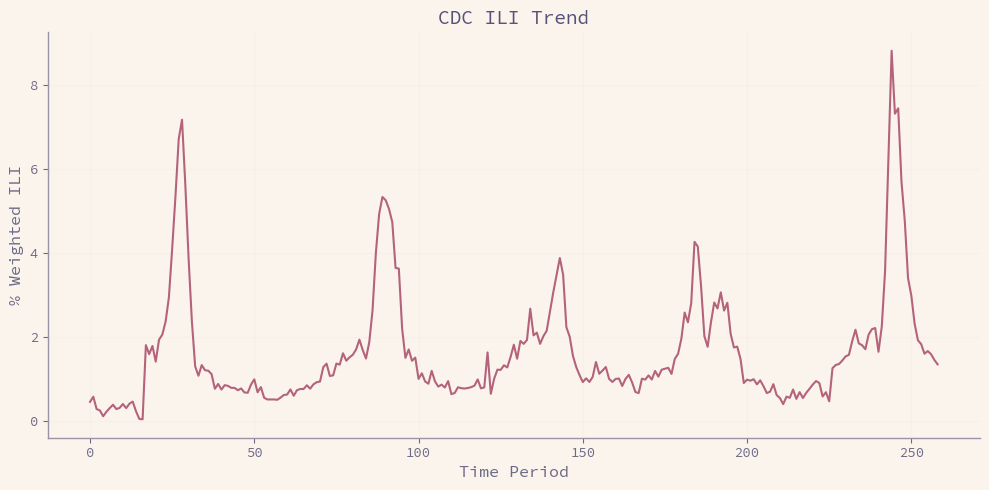

In [14]:
import matplotlib.pyplot as plt
plt.style.use(r"D:\CALCULATION\12.17google_flu\rose-pine-dawn.mplstyle")



plt.figure(figsize=(10, 5))
plt.plot(dat.index, y)
plt.title("CDC ILI Trend", fontsize=14)
plt.xlabel("Time Period", fontsize=12)
plt.ylabel("% Weighted ILI", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



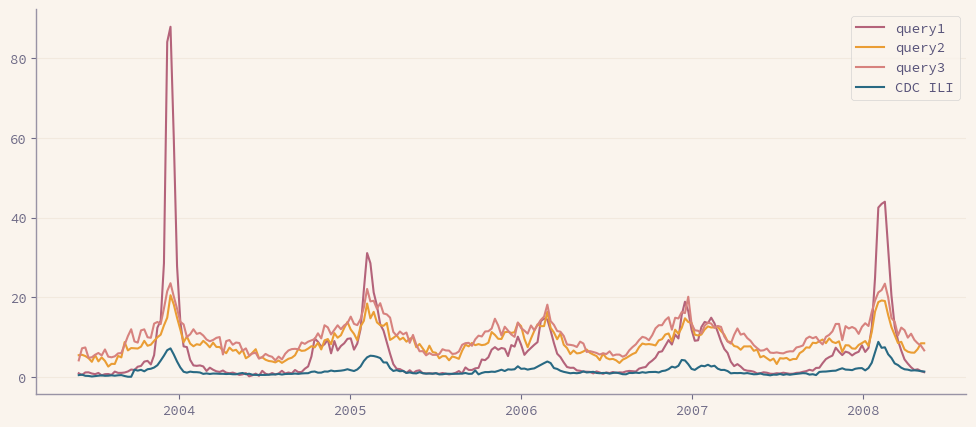

In [15]:
dat['Date'] = pd.to_datetime(dat['Date']) 

# 2. 设置风格
plt.style.use(r"D:\CALCULATION\12.17google_flu\rose-pine-dawn.mplstyle")

# 3. 绘图
plt.figure(figsize=(12, 5))
plt.plot(dat['Date'], dat['query1'], label = 'query1')
plt.plot(dat['Date'], dat['query2'], label = 'query2')
plt.plot(dat['Date'], dat['query3'], label = 'query3')
plt.plot(dat['Date'], y,  label = 'CDC ILI')
plt.legend()
plt.show()


In [16]:
dat['y'] = y.tolist()

In [17]:
dat.columns

Index(['Date', 'query1', 'query2', 'query3', 'query4', 'query5', 'query6',
       'query7', 'query8', 'query9', 'query10', 'query11', 'query12',
       'query13', 'query14', 'query15', 'query16', 'query17', 'query18',
       'query19', 'query20', 'query21', 'query22', 'query23', 'query24',
       'query25', 'query26', 'query27', 'query28', 'query29', 'query30',
       'query31', 'query32', 'query33', 'query34', 'query35', 'query36',
       'query37', 'query38', 'query39', 'query40', 'query41', 'query42',
       'query43', 'query44', 'query45', 'y'],
      dtype='object')

In [18]:
# 1. 创建一个新列 'trend'，表示趋势项
dat['trend'] = range(1,len(dat)+1)

# winter 12月，1月，2月
dat['winter'] = [1 if i.month in [12, 1, 2] else 0 for i in dat['Date'] ]

In [19]:
# 特征工程 - 构建滞后特征
# 看看前7周的流感情况对当前周的搜索量的影响

for i in range(1, 8): 
    dat["lag_{}".format(i)] = dat['y'].shift(i)    # .shift(i): 平移函数,把整列数据向下移动 i 格
print("done")
dat=dat.fillna(0) # 填补空缺

done


In [20]:
y = dat['y']
date = dat['Date']
X = dat.drop(['y', 'Date'], axis = 1)

In [26]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit

def train_the_model(X):

    # 设定训练集大小为前100个时间点

    N = 100
    y = dat['y']
    X_train = X.iloc[:N,]
    X_test = X.iloc[N:,]
    y_train = y[:N]
    y_test = y[N:]
    date = dat['Date']

    # 利用弹性网络
    from sklearn.model_selection import cross_val_score
    tscv = TimeSeriesSplit(n_splits=5)
    base_model = ElasticNetCV(

                            # L1和L2正则化的混合比例，0.5表示等权重混合
                            l1_ratio=0.5, 

                            # alpha值的最小比例
                            eps=1e-3, 

                            # 测试200个不同的正则化强度
                            n_alphas=200, 

                            cv=tscv,

                            fit_intercept=True, 

                            precompute='auto', 

                            # 最大迭代次数和收敛容忍度
                            max_iter=500, tol=0.006, 
                            
                            
                            copy_X=True, 
                            verbose=0, 
                            n_jobs=-1, positive=False, random_state=0)


    cv_model = make_pipeline(StandardScaler(), base_model)
    # 训练模型              
    cv_model.fit(X_train, y_train)

    # 计算最佳迭代次数、alpha和ratio

    
    print('最佳 alpha: %.8f'%cv_model[-1].alpha_)
    print('最佳 l1_ratio: %.3f'%cv_model[-1].l1_ratio_)
    print('迭代次数 %d'%cv_model[-1].n_iter_)

    # 输出结果
    y_train_pred = cv_model.predict(X_train)
    y_pred = cv_model.predict(X_test)

    
    # __R² Score__: 决定系数，衡量模型解释方差的比例（越接近1越好）
    print('Train r2 score: ', r2_score(y_train, y_train_pred))
    print('Test r2 score: ', r2_score(y_test, y_pred))
    train_mse = mean_squared_error(y_train_pred, y_train)
    test_mse = mean_squared_error(y_pred, y_test)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    # __RMSE__: 均方根误差，衡量预测值与真实值的平均偏差
    print('Train RMSE: %.4f' % train_rmse)
    print('Test RMSE: %.4f' % test_rmse)

    import datetime
    plt.style.use(r"D:\CALCULATION\12.17google_flu\rose-pine-dawn.mplstyle")

    plt.rcParams.update({'figure.figsize': (15, 5)})

    plt.plot(date, y)
    plt.plot(date[N:], y_pred)
    plt.legend(['CDC ILI', 'Predicted'])
    plt.show()



最佳 alpha: 0.01579995
最佳 l1_ratio: 0.500
迭代次数 148
Train r2 score:  0.9683576506704813
Test r2 score:  0.8850918375678518
Train RMSE: 0.2722
Test RMSE: 0.4398


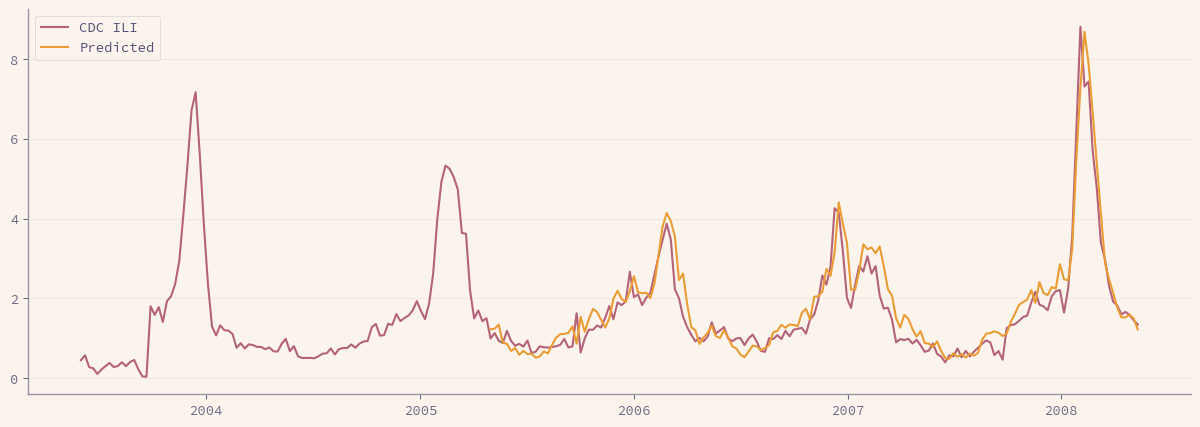

In [27]:
dat['date'] = dat['Date']

X = dat.drop(['y', 'Date', 'date', 'trend', 'winter'], axis = 1)

train_the_model(X)